# Spruce tree type detection

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import tabulate as tabulate

## Creating the Dataframe based on Dataset 'Spruce.csv'

In [17]:
data = pd.read_csv("dataset/Spruce.csv")

data.head()

,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Fire_Points,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,...,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Tree_Type
0,2596,3,258,0,510,6279,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Other
1,2590,2,212,-6,390,6225,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Other
2,2804,9,268,65,3180,6121,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Other
3,2785,18,242,118,3090,6211,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Other
4,2595,2,153,-1,391,6172,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Other


## 1. Exploratory Data Analysis (EDA)
### Check the class distribution and visualize it

Tree_Type
Other     12960
Spruce     2160
Name: count, dtype: int64


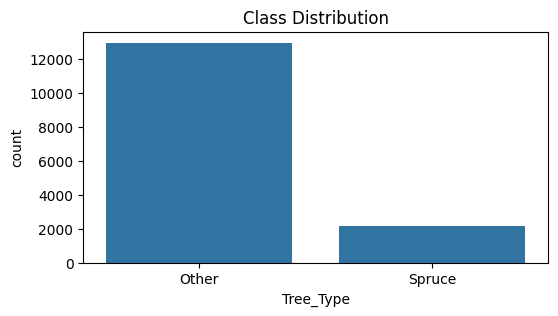

In [18]:
print(data['Tree_Type'].value_counts())

plt.figure(figsize=(6, 3))
sns.countplot(x='Tree_Type', data=data)
plt.title('Class Distribution')
plt.show()

## 2. Data Pre-processing

### Encode categorical variable 'Tree_Type'

In [19]:
label_encoder = LabelEncoder()
data['Tree_Type'] = label_encoder.fit_transform(data['Tree_Type'])

### Replace Soil_Type1 to Soil_Type38 with a single column Soil_Type

In [20]:
soil_type_cols = [f'Soil_Type{i}' for i in range(1, 39)]
data['Soil_Type'] = data[soil_type_cols].idxmax(axis=1).str.extract(r'(\d+)').astype(int)
data.drop(soil_type_cols, axis=1, inplace=True)

### Split the dataset into training and testing sets


In [21]:
X = data.drop('Tree_Type', axis=1)
y = data['Tree_Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standardize/normalize data if necessary


In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

data.describe().round(2)

,Elevation,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Fire_Points,Tree_Type,Soil_Type
count,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00,15120.00
mean,2749.32,16.50,227.20,51.08,1714.02,1511.15,0.14,17.87
std,417.68,8.45,210.08,61.24,1325.07,1099.94,0.35,11.89
min,1863.00,0.00,0.00,-146.00,0.00,0.00,0.00,1.00
25%,2376.00,10.00,67.00,5.00,764.00,730.00,0.00,9.00
50%,2752.00,15.00,180.00,32.00,1316.00,1256.00,0.00,15.00
75%,3104.00,22.00,330.00,79.00,2270.00,1988.25,0.00,28.00
max,3849.00,52.00,1343.00,554.00,6890.00,6993.00,1.00,38.00


## 3. Identification of Target Concept
### Analysing the target variable 'Tree_Type' and its correlation with the other Features

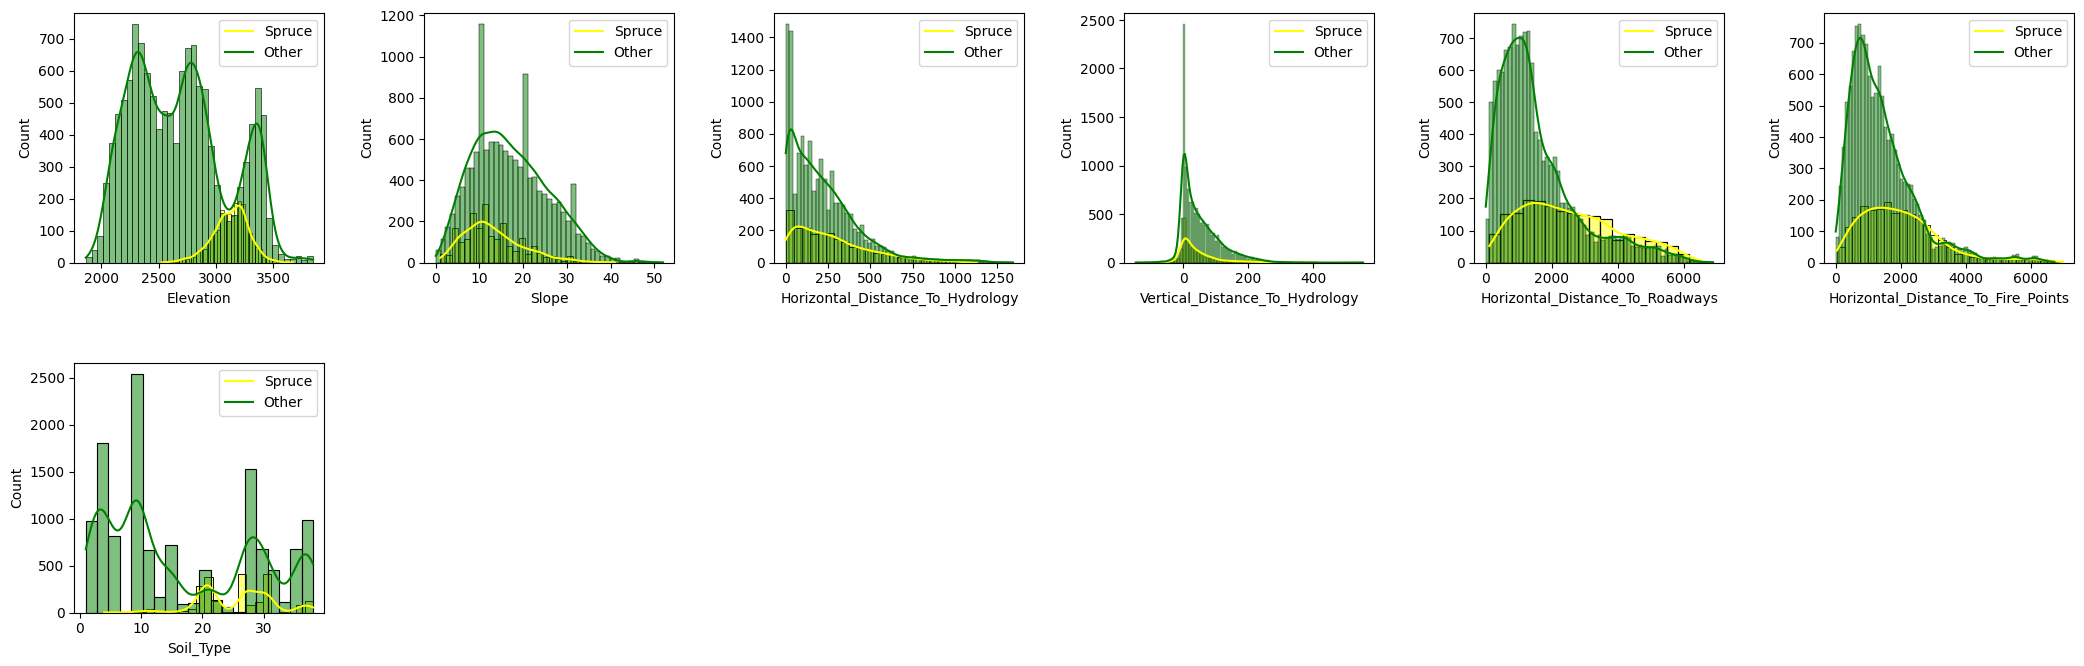

In [23]:
df1 = data[data['Tree_Type'] == 1]
df2 = data[data['Tree_Type'] == 0]

df1 = df1.drop(['Tree_Type'], axis=1)
df2 = df2.drop(['Tree_Type'], axis=1)

cols = list(df1.columns)

plt.figure(figsize=(25, 25))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

for i, col in enumerate(cols):
    plt.subplot(6, 6, i + 1)
    sns.histplot(data=df1[col], color='yellow', label='Spruce', kde=True)
    sns.histplot(data=df2[col], color='green', label='Other', kde=True)
    _, axes = plt.gca().get_legend_handles_labels()
    plt.legend(axes, prop={'size': 10})

plt.show()

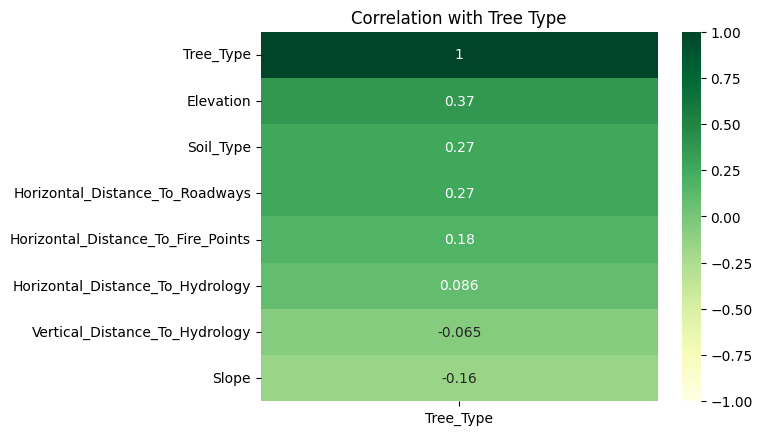

In [24]:
corr = data.corr()['Tree_Type'].sort_values(ascending=False)

# Plot the correlation heatmap
sns.heatmap(corr.to_frame(), annot=True, cmap='YlGn', vmin=-1, vmax=1)
plt.title('Correlation with Tree Type')

plt.show()

### Correlation Between Features

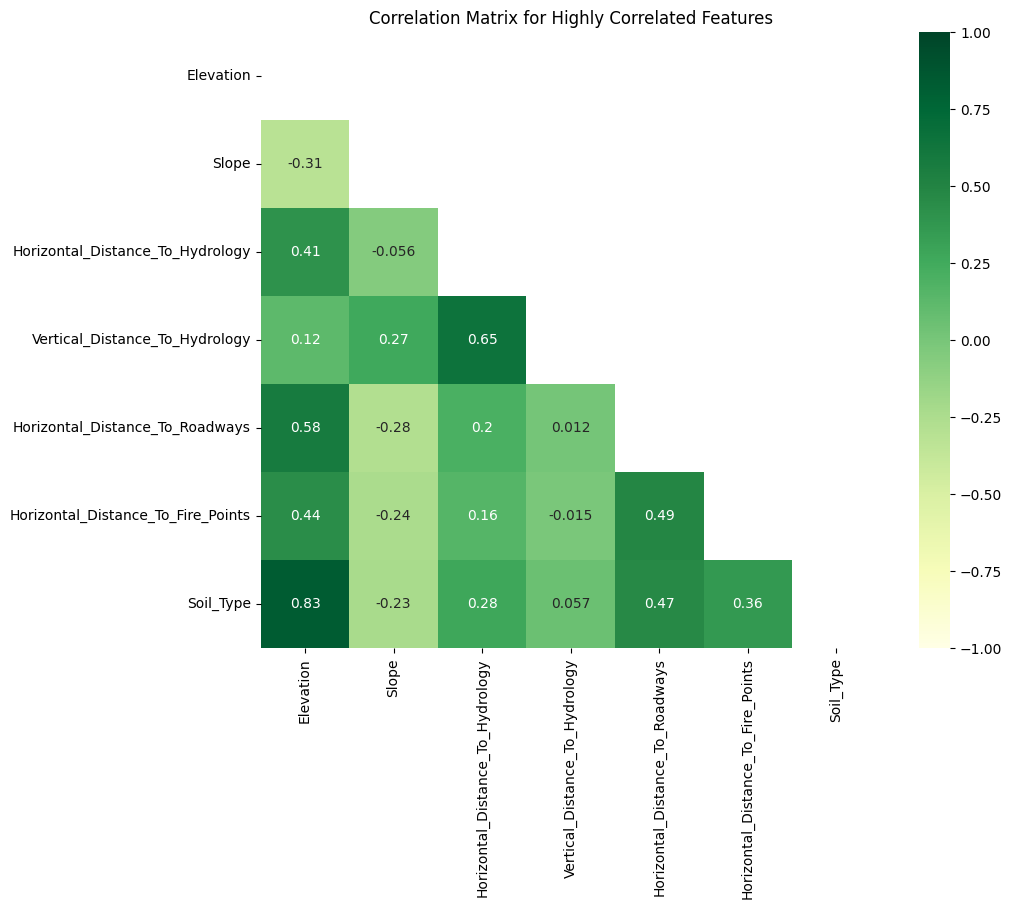

In [25]:
corr_matrix = data.drop('Tree_Type', axis=1).corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a new DataFrame with only the features that have a correlation greater than 0.95
high_corr_features = corr_matrix.loc[corr_matrix.abs().unstack().sort_values(kind='quicksort').unstack().values >= 0.95].dropna(axis=1, how='all').dropna(axis=0, how='all')

# Plot the correlation matrix for the highly correlated features
plt.figure(figsize=(10, 8))
sns.heatmap(high_corr_features, annot=True, cmap='YlGn', mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Matrix for Highly Correlated Features')
plt.show()

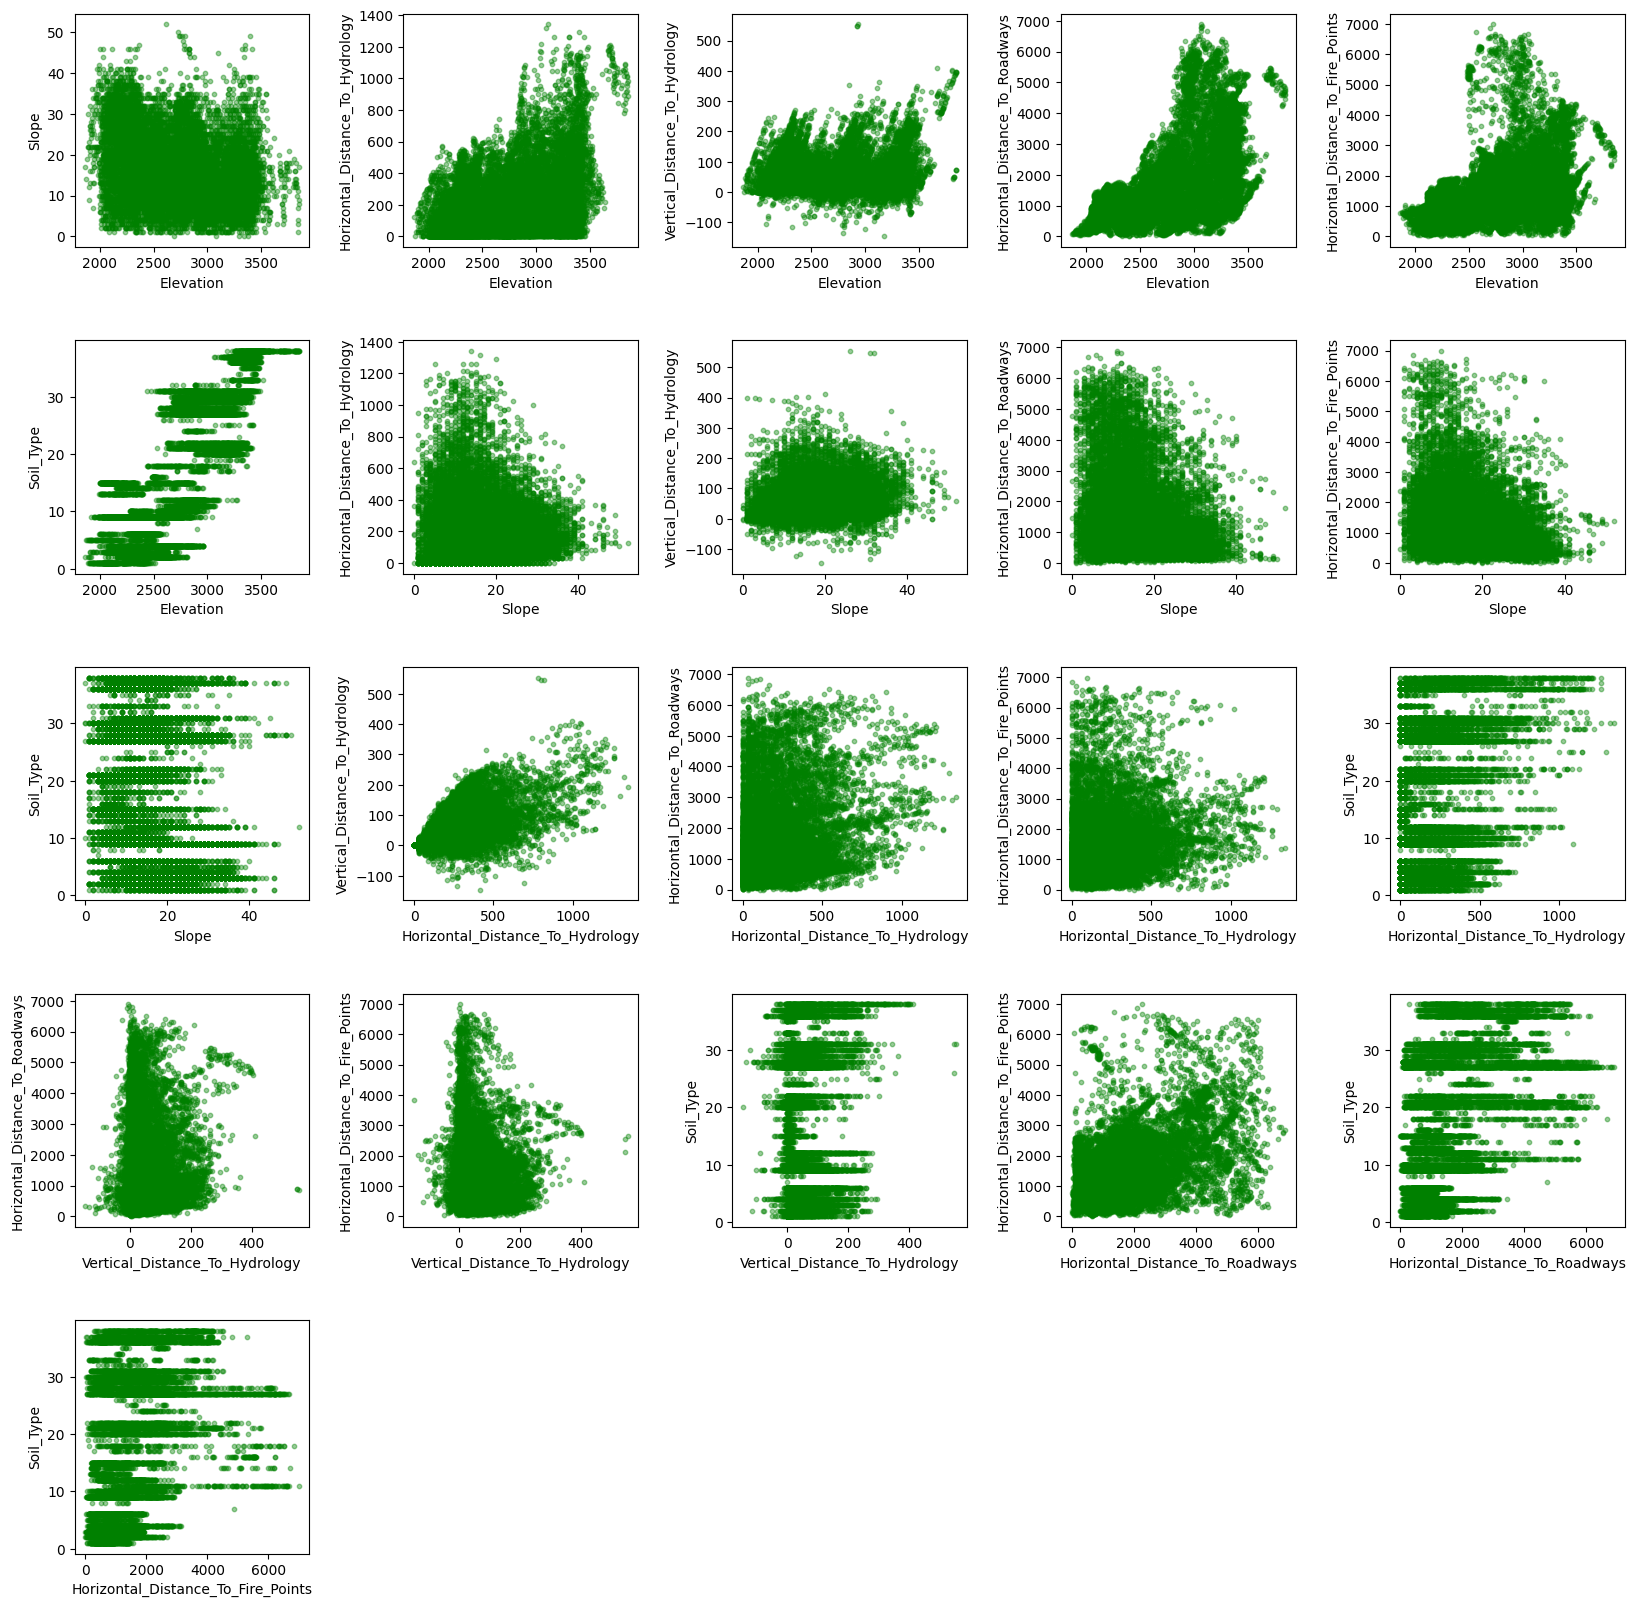

In [26]:
cols = list(data.columns)

# Remove the target variable ('Tree_Type') from the list of columns
cols.remove('Tree_Type')

plot_cols = []

# Calculate pairwise correlations
for i, col1 in enumerate(cols):
    for col2 in cols[i+1:]:
        corr = math.fabs(data[col1].corr(data[col2]))
        corr = round(corr, 2)
        plot_cols.append([col1, col2])

# Check if any pairs were found
if not plot_cols:
    print("No pairs of columns with correlation > 0 were found.")
else:
    # Calculate the number of rows and columns for the grid
    num_plots = len(plot_cols)
    num_rows = int(math.ceil(math.sqrt(num_plots)))
    num_cols = int(math.ceil(num_plots / num_rows))

    # Create a figure and adjust the subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    # Flatten the axs array for easier iteration
    axs = axs.flatten()

    for ax, cols in zip(axs, plot_cols):
        ax.scatter(data[cols[0]], data[cols[1]], s=10, c='green', alpha=0.4)
        ax.set_xlabel(cols[0], fontsize=10)
        ax.set_ylabel(cols[1], fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=10)

    # Remove any unused subplots
    for ax in axs[len(plot_cols):]:
        ax.axis('off')

    plt.show()

### Create a new dataframe without the lowest correlation features

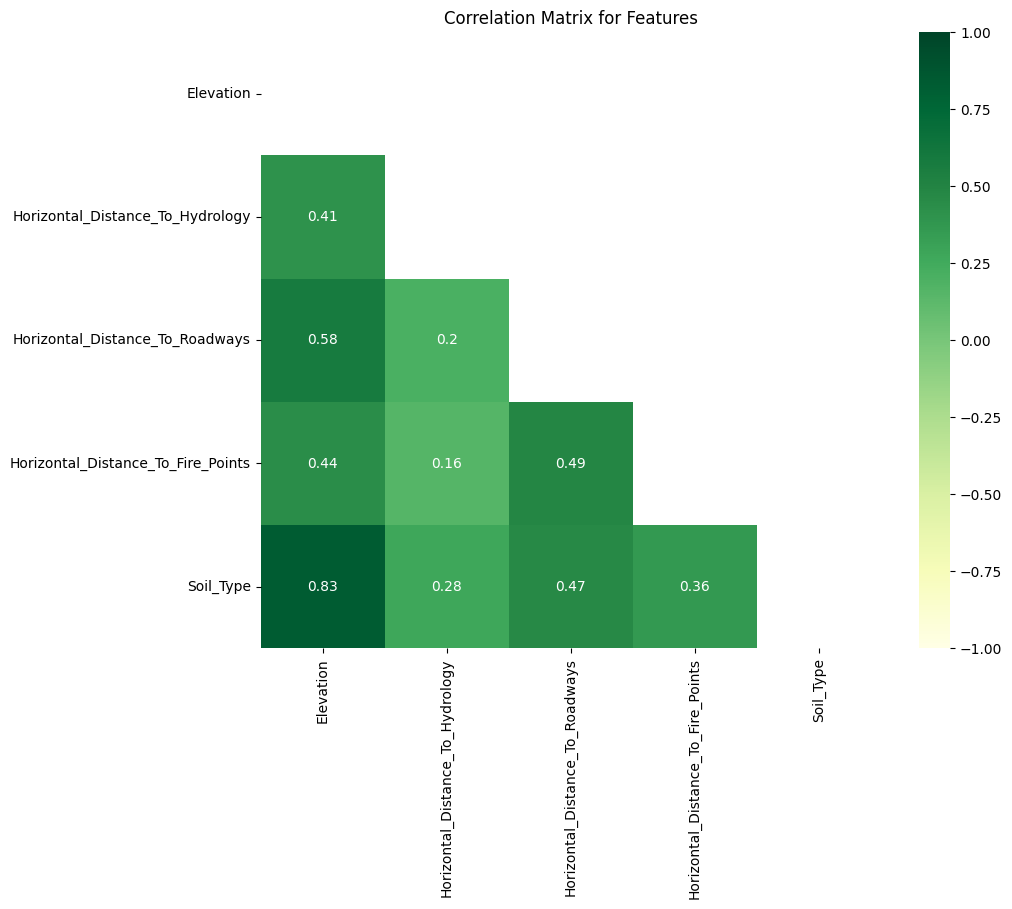

In [27]:
# Create a new dataframe with the low correlated features removed
data_new = data.copy()
data_new = data_new.drop(['Slope', 'Vertical_Distance_To_Hydrology'], axis=1)

corr_matrix = data_new.drop('Tree_Type', axis=1).corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a new DataFrame with only the features that have a correlation greater than 0.95
high_corr_features = corr_matrix.loc[corr_matrix.abs().unstack().sort_values(kind='quicksort').unstack().values >= 0.95].dropna(axis=1, how='all').dropna(axis=0, how='all')

# Plot the correlation matrix for the highly correlated features
plt.figure(figsize=(10, 8))
sns.heatmap(high_corr_features, annot=True, cmap='YlGn', mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Matrix for Features')
plt.show()


## 4. Selection and Parameterization of Learning Algorithms
### Initialize models


In [28]:
X = data_new.drop('Tree_Type', axis=1)
y = data_new['Tree_Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

data_new.describe().round(2)

models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    KNeighborsClassifier(),
    SVC(),
    LogisticRegression(),
    GaussianNB(),
    MLPClassifier(),
    XGBClassifier(),
    LGBMClassifier(verbose=-1),
    CatBoostClassifier(verbose=0)
]

## 5. Training and Evaluation
### Train and evaluate models

In [29]:
model_names = ['DTC', 'RFC', 'GBC', 'KNC', 'SVC', 'LR', 'GNB', 'MLP', 'XGB', 'LGBM', 'CatBoost']
accuracies = []
f1_scores = []
confusion_matrices = []

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred) * 100)
    f1_scores.append(f1_score(y_test, y_pred, average='macro') * 100)
    confusion_matrices.append(confusion_matrix(y_test, y_pred))

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## 6. Results Comparison
### Visualize and compare results

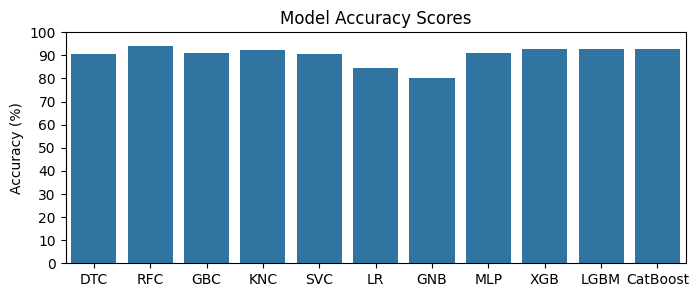

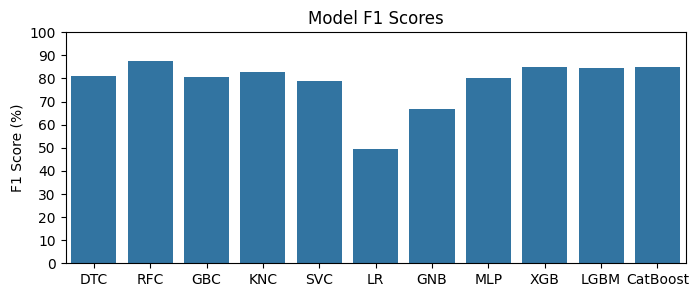

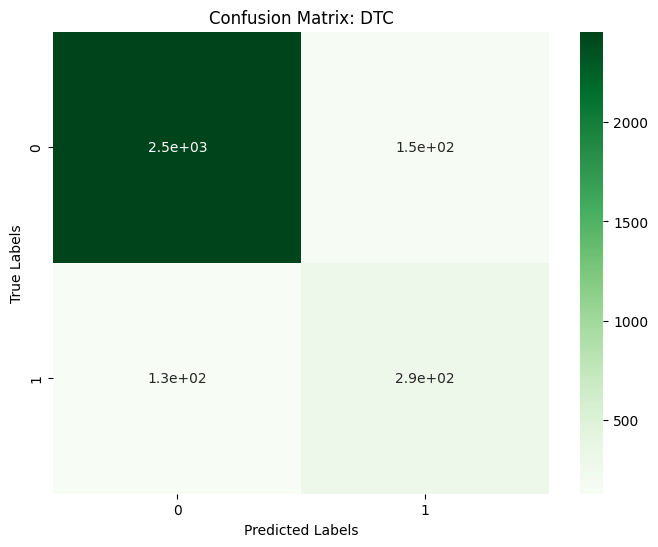

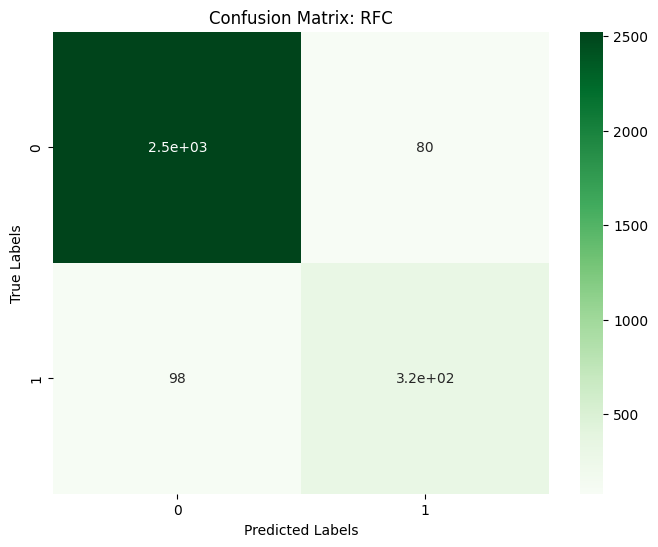

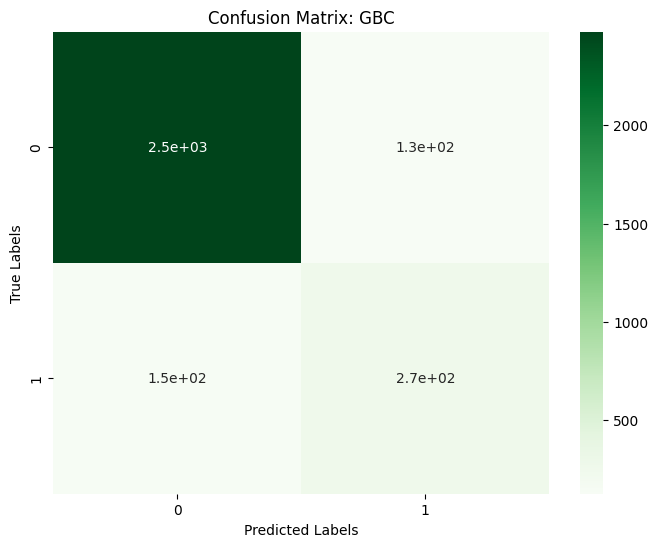

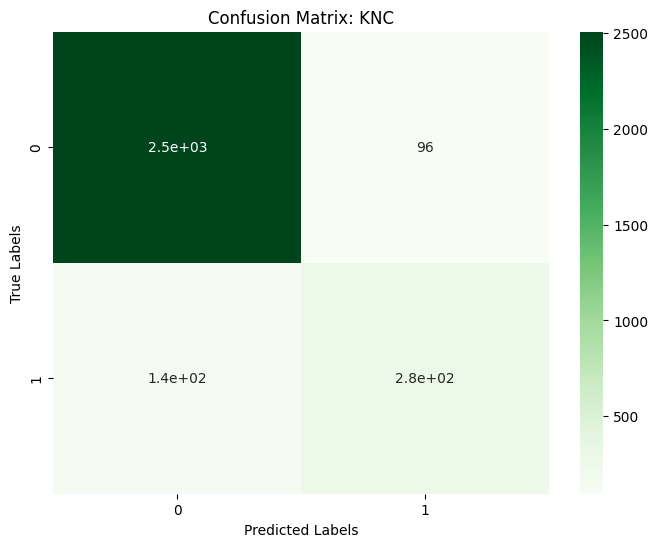

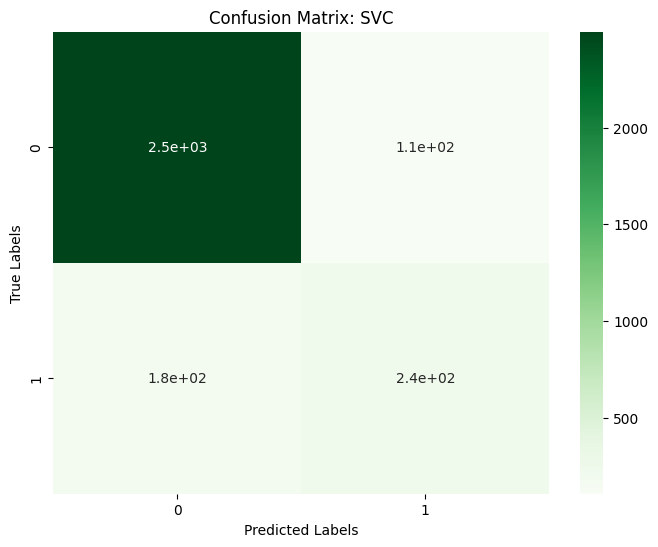

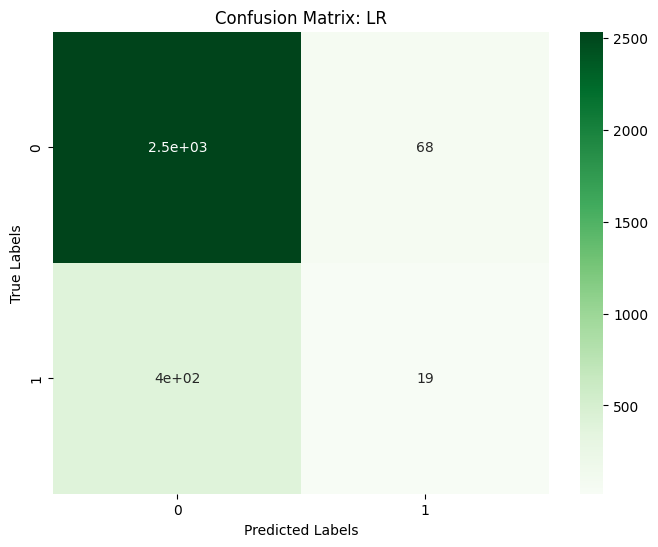

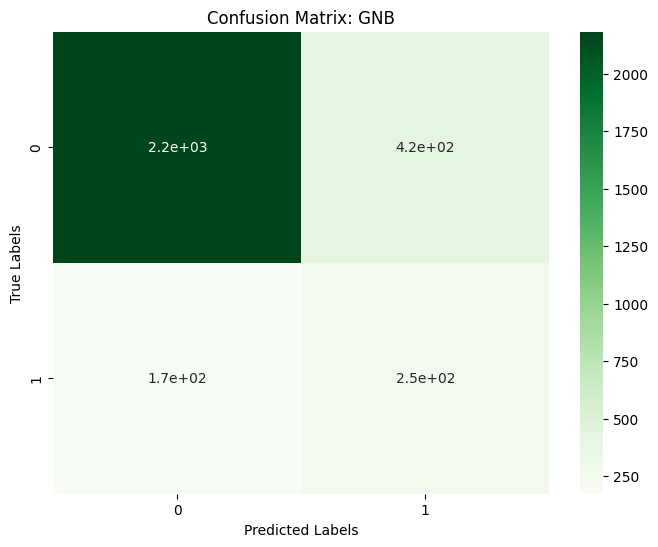

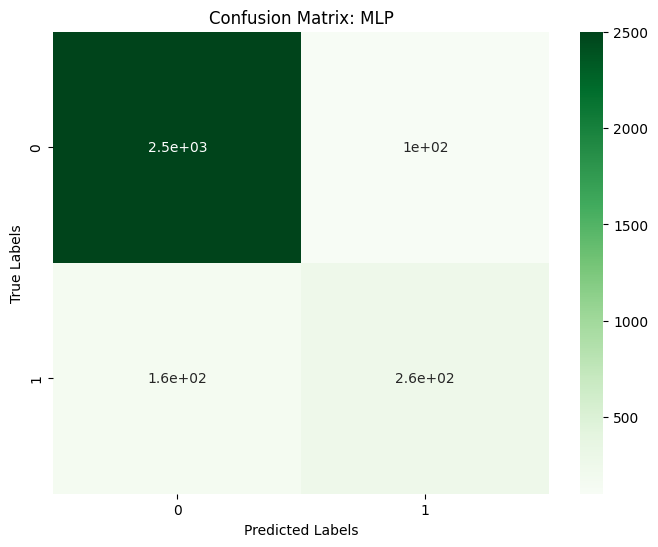

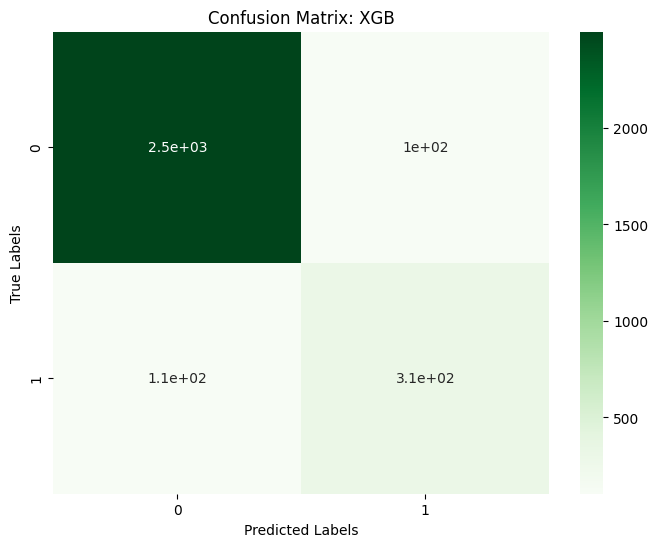

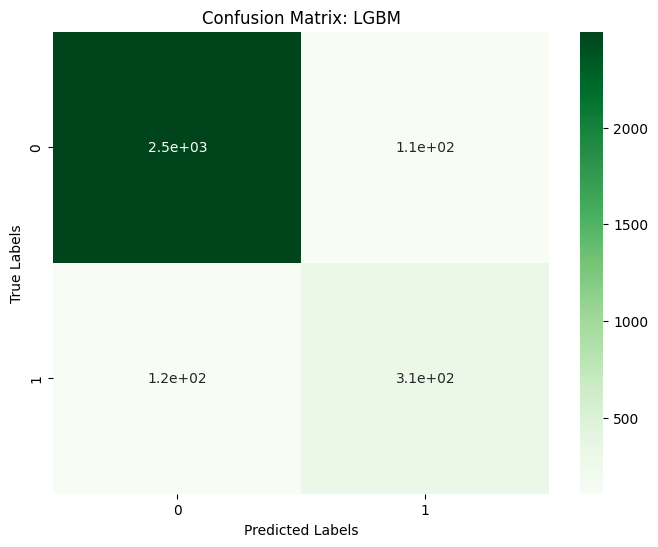

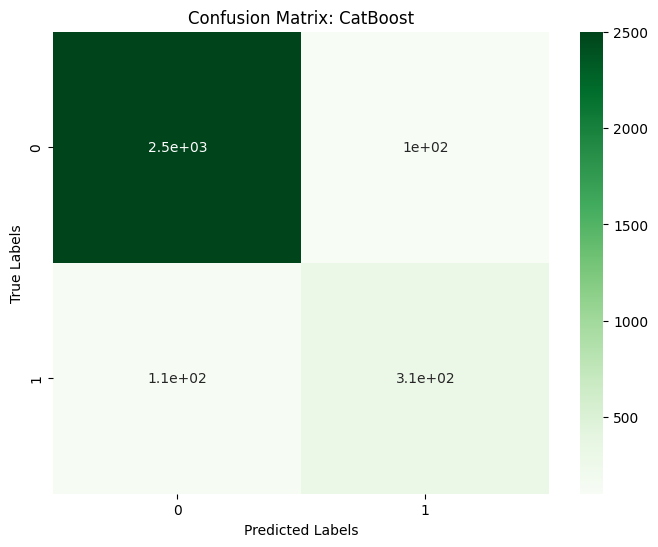

In [30]:
# Visualize Accuracy scores
plt.figure(figsize=(8, 3))
sns.barplot(x=model_names, y=accuracies)
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.yticks(np.arange(0, 101, 10))
plt.title('Model Accuracy Scores')
plt.show()

# Visualize F1 scores
plt.figure(figsize=(8, 3))
sns.barplot(x=model_names, y=f1_scores)
plt.ylabel('F1 Score (%)')
plt.ylim(0, 100)
plt.yticks(np.arange(0, 101, 10))
plt.title('Model F1 Scores')
plt.show()

# Visualize confusion matrices
for i, confusion_matrix in enumerate(confusion_matrices):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, cmap='Greens')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix: {model_names[i]}')
    plt.show()